In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1274.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1271.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1283.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1204.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1200.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1310.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1299.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1202.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1276.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1225.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1217.jpg
/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation/pituitary/Tr-pi_1

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


In [4]:
train_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Training"
val_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Validation"
test_dir = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing"


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [6]:
# Get the class names (folder names)
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)

# Dictionary to store one image path from each class
image_paths = {class_name: os.path.join(train_dir, class_name, os.listdir(os.path.join(train_dir, class_name))[0])
               for class_name in class_names}


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


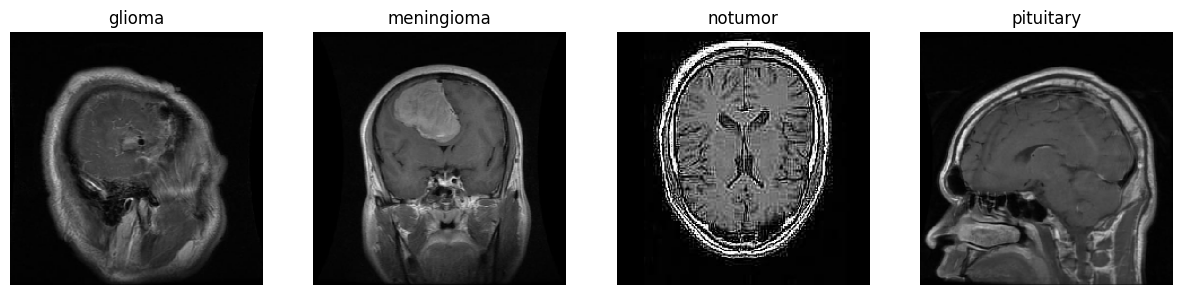

In [7]:
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

for ax, (class_name, image_path) in zip(axes, image_paths.items()):
    img = load_img(image_path, target_size=(224, 224))  # Load image
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")  # Hide axis

plt.show()


**Data Augmentation**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
img_height = 224
img_width = 224
batch_size = 32

In [10]:
img_size = (img_height, img_width)

In [11]:
import keras
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal",
                     input_shape=(img_height,
                                 img_width,
                                  3)),

    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training Data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Training Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Validation & Testing Data Generators (Only Rescaling)
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load Training Images
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

# Load Validation Images
val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical'
)

# Load Testing Images (Without Shuffling for Consistent Predictions)
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical', shuffle=False
)


Found 4672 images belonging to 4 classes.
Found 576 images belonging to 4 classes.
Found 576 images belonging to 4 classes.


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


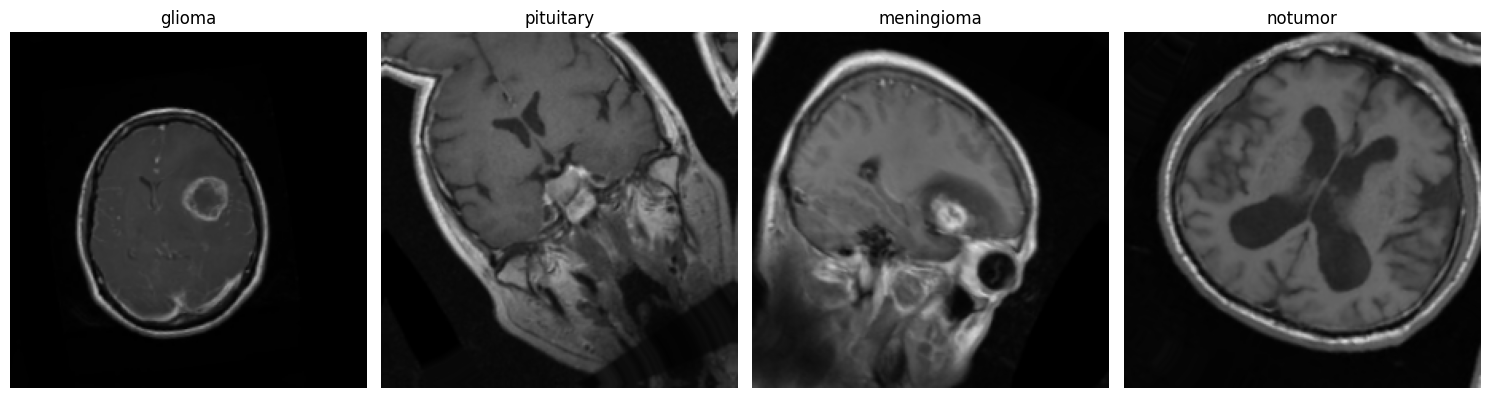

In [13]:
# Get class names
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)

# Initialize plot
fig, axes = plt.subplots(1, len(class_names), figsize=(15, 5))

# Dictionary to store one augmented image per class
displayed_classes = set()

# Iterate through the dataset to find one image per class
for images, labels in train_generator:
    for i in range(len(labels)):
        class_index = np.argmax(labels[i])  # Get class index
        class_name = class_names[class_index]

        if class_name not in displayed_classes:
            # Apply augmentation
            augmented_img = data_augmentation(tf.expand_dims(images[i], axis=0))

            # Display image
            axes[len(displayed_classes)].imshow(augmented_img[0])
            axes[len(displayed_classes)].set_title(class_name)
            axes[len(displayed_classes)].axis("off")

            displayed_classes.add(class_name)

        if len(displayed_classes) == len(class_names):  # Stop when all classes are covered
            break
    if len(displayed_classes) == len(class_names):
        break

plt.tight_layout()
plt.show()


In [14]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [15]:
# Define EarlyStopping (Stop training when no improvement in val_loss)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Stop after 10 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# Define ModelCheckpoint (Save the best model)
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# ReduceLROnPlateau (Reduce learning rate if val_loss stops improving)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=5,  # Wait for 5 epochs before reducing LR
    min_lr=1e-6,  # Set a lower limit for LR
    verbose=1
)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Define the model
model = tf.keras.Sequential([
    # Convolutional Block 1
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same", input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Convolutional Block 2
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Convolutional Block 3
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Convolutional Block 4
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Fully Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.L2(1e-4)),
    tf.keras.layers.Dropout(0.3),

    # Output Layer
    tf.keras.layers.Dense(units=4, activation='softmax'),
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 56,202,308 (214.39 MB)

 Trainable params: 56,200,388 (214.39 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
# Train the model with the updated callbacks
history = model.fit(
    train_generator,
    epochs=200,  # Train for up to 200 epochs
    validation_data=val_generator,  # Use validation set for monitoring
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Updated callbacks
)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.5543 - loss: 1.8997
Epoch 1: val_loss improved from inf to 1.79032, saving model to best_model.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 161s 769ms/step - accuracy: 0.5547 - loss: 1.8972 - val_accuracy: 0.2500 - val_loss: 1.7903 - learning_rate: 1.0000e-04
Epoch 2/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.6770 - loss: 1.0667
Epoch 2: val_loss did not improve from 1.79032
146/146 ━━━━━━━━━━━━━━━━━━━━ 66s 435ms/step - accuracy: 0.6771 - loss: 1.0667 - val_accuracy: 0.3872 - val_loss: 1.8454 - learning_rate: 1.0000e-04
Epoch 3/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.7128 - loss: 0.8838
Epoch 3: val_loss did not improve from 1.79032
146/146 ━━━━━━━━━━━━━━━━━━━━ 65s 428ms/step - accuracy: 0.7129 - loss: 0.8837 - val_accuracy: 0.4549 - val_loss: 4.8688 - learning_rate: 1.0000e-04
Epoch 4/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.7755 - loss: 0.7302
Epoch 4: val_loss improved from 1.79

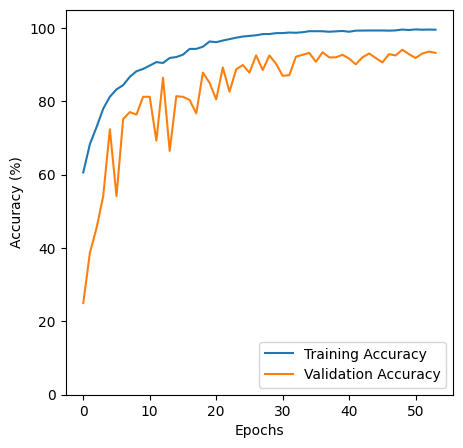

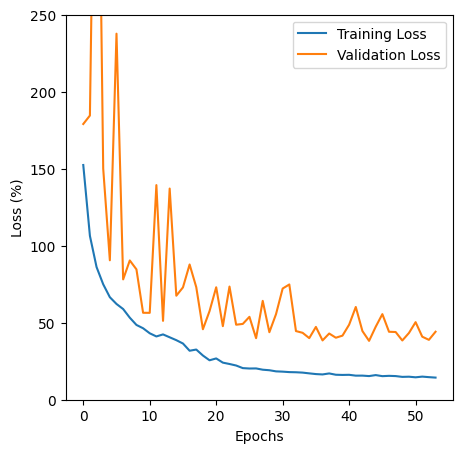

In [24]:
import matplotlib.pyplot as plt

# Extract training and validation metrics
acc = [a * 100 for a in history.history['accuracy']]
val_acc = [a * 100 for a in history.history['val_accuracy']]
loss = [b * 100 for b in history.history['loss']]
val_loss = [b * 100 for b in history.history['val_loss']]
epochs_range = range(len(acc))

# Plot Training & Validation Accuracy
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title("Training & Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.ylim([0, 105])  # Ensure values stay within range
#plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines for better visualization
plt.savefig('Custom2_200_training_validation_accuracy.png')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(5, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
#plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.ylim([0, 250])
#plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('Custom2_200_training_validation_loss.png')
plt.show()


In [21]:
model.evaluate(train_generator) # Training accuracy and loss

146/146 ━━━━━━━━━━━━━━━━━━━━ 52s 356ms/step - accuracy: 0.9962 - loss: 0.1486


[0.145249143242836, 0.9974315166473389]

In [22]:
model.evaluate(val_generator) # Validation accuracy and loss

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9222 - loss: 0.4284


[0.38219740986824036, 0.9305555820465088]

In [23]:
model.evaluate(test_generator) # Testing accuracy and loss

18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step - accuracy: 0.9875 - loss: 0.1849


[0.18678976595401764, 0.9861111044883728]

In [26]:
num_classes = 4

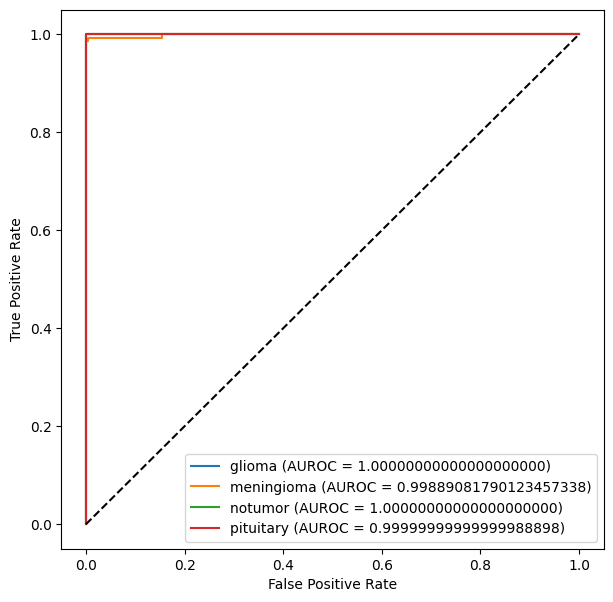

In [42]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Get true labels and one-hot encode them
y_true = test_generator.classes  # True labels from test set
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Predict probabilities in one step (faster execution)
y_pred_probs = model.predict(test_generator, verbose=0)

# Create figure for ROC curves
plt.figure(figsize=(7, 7))

# Compute and plot ROC curve for each class
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUROC = {roc_auc:.20f})')

# Formatting
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
#plt.grid(True, linestyle='--', alpha=0.6)

# Save and display the AUROC plot
plt.savefig('Custom2_AUROC.png', dpi=300, bbox_inches='tight')
plt.show()


In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Get true labels and one-hot encode them
y_true = test_generator.classes  # True labels from test set
y_true_binarized = label_binarize(y_true, classes=np.arange(num_classes))

# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=0)

# Compute AUROC for each class
auroc_values = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)  # Compute AUROC
    auroc_values.append(roc_auc)

# Print exact AUROC values (no rounding)
print("AUROC values for each class:", auroc_values)


AUROC values for each class: [1.0, 0.9988908179012346, 1.0, 0.9999999999999999]


**Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


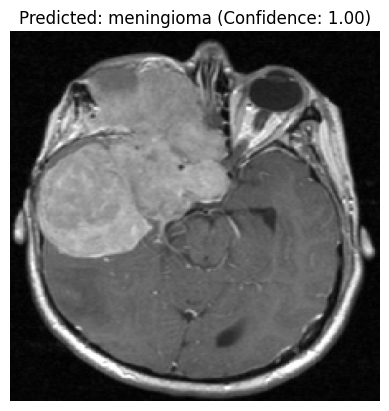

In [47]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Select an image from the testing set
test_image_path = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0018.jpg"  # Change this to any test image path

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(224, 224))  # Resize to ResNet50 input size
img_array = image.img_to_array(img)  # Convert to NumPy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize (if preprocessing requires)

# Make prediction
pred_probs = model.predict(img_array)
pred_class = np.argmax(pred_probs, axis=1)[0]  # Get the class index

# Get class label
pred_class_name = class_names[pred_class]  # Assuming class_names contains the actual labels

# Display image with prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {pred_class_name} (Confidence: {pred_probs[0][pred_class]:.2f})")
plt.show()


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# y_true is already in label format, so don't apply argmax
y_true_classes = y_true  # No need for np.argmax
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Generate classification report and confusion matrix
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))
print(confusion_matrix(y_true_classes, y_pred_classes))


              precision    recall  f1-score   support

      glioma       0.97      1.00      0.99       144
  meningioma       1.00      0.94      0.97       144
     notumor       0.98      1.00      0.99       144
   pituitary       0.99      1.00      1.00       144

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576

[[144   0   0   0]
 [  4 136   3   1]
 [  0   0 144   0]
 [  0   0   0 144]]


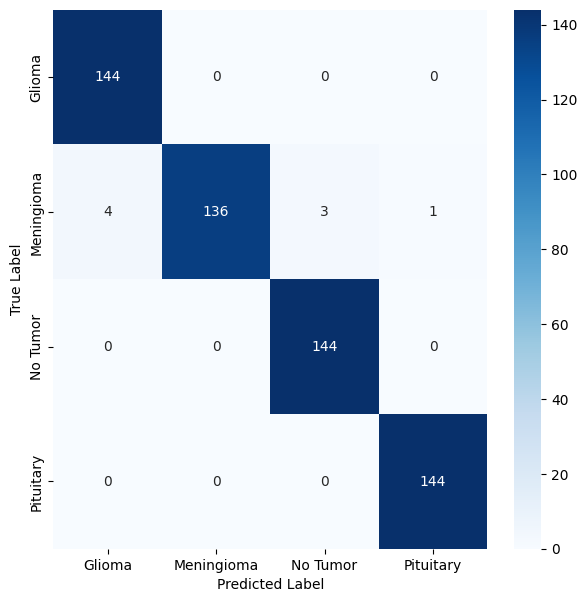

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))

# Define class names (Modify as per your dataset)
class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Formatting
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('Custom2_200_confusion_matrix.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


**Explainable AI**

**Occlusion Sensitivity**

In [51]:
IMG_SIZE = (224, 224)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

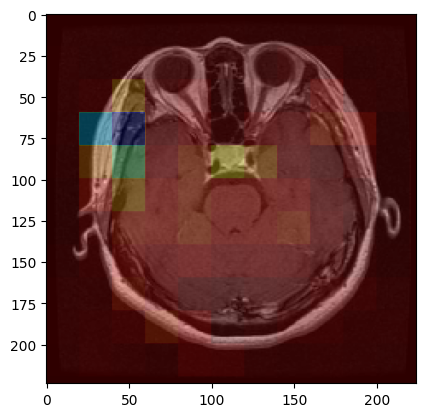

In [54]:
def occlusion_sensitivity(img_path, model, patch_size=20):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    occlusion_map = np.zeros_like(img_array[0, :, :, 0])

    for i in range(0, IMG_SIZE[0], patch_size):
        for j in range(0, IMG_SIZE[1], patch_size):
            occluded_img = img_array.copy()
            occluded_img[0, i:i+patch_size, j:j+patch_size, :] = 0

            prediction = model.predict(occluded_img)
            class_idx = np.argmax(prediction[0])

            occlusion_map[i:i+patch_size, j:j+patch_size] = prediction[0][class_idx]

    plt.imshow(img)
    plt.imshow(occlusion_map, cmap='jet', alpha=0.3)
    plt.show()

# Run Occlusion Sensitivity
occlusion_sensitivity("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/pituitary/Te-pi_0011.jpg", model)


**LIME**

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

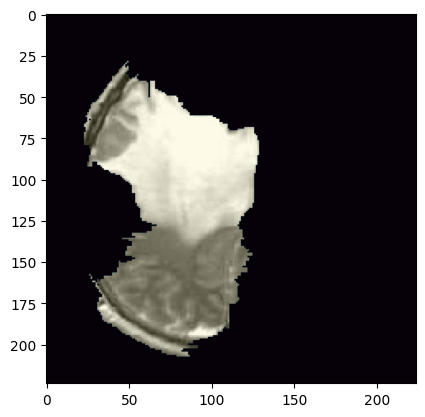

In [57]:
from lime import lime_image

def explain_lime(img_path, model):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array.astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True
    )

    plt.imshow(temp)
    plt.imshow(mask, alpha=0.1)
    plt.show()

explain_lime("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0036.jpg", model)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

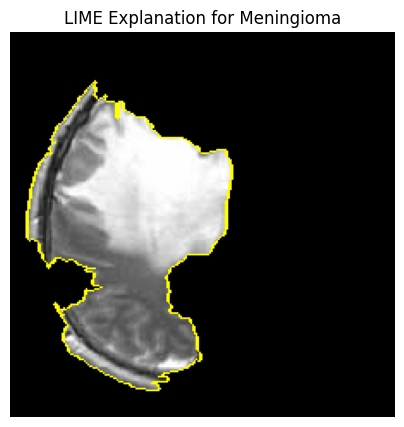

In [58]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from lime.lime_image import LimeImageExplainer  # Correct Import
from skimage.segmentation import mark_boundaries

def explain_lime(img_path, model, class_names):
    # Load and preprocess the image
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Initialize the LIME Explainer
    explainer = LimeImageExplainer()

    # Explain the model's prediction
    explanation = explainer.explain_instance(
        img_array[0].astype('double'),
        model.predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Get LIME mask and overlay on image
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True
    )

    # Display the explanation
    plt.figure(figsize=(5, 5))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for {class_names[explanation.top_labels[0]]}")
    plt.axis("off")
    plt.show()

# Run LIME
explain_lime("/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0036.jpg", model, class_names)


**GradCAM**

In [59]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 168,603,086 (643.17 MB)

 Trainable params: 56,200,388 (214.39 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 112,400,778 (428.77 MB)

In [66]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get predicted class
        class_channel = predictions[:, pred_index]

    # Compute the gradient of the class output with respect to feature maps
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the feature maps with gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Avoid division by zero
    
    return heatmap.numpy()

# Load an image and preprocess it
img_path = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0036.jpg"
img = cv2.imread(img_path)

# Check if the image was loaded correctly
if img is None:
    raise ValueError(f"Error: Image not found at {img_path}")

# Resize and normalize the image
img = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img, axis=0) / 255.0  # Normalize

# Ensure the model is built by making a real prediction
_ = model.predict(img_array)

# Generate Grad-CAM heatmap
last_conv_layer_name = "conv2d_7"  # Update this with the actual last Conv layer name
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose heatmap on original image
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Show the result
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


ValueError: The layer sequential_2 has never been called and thus has no defined input.

**SHAP**

In [ ]:
import shap
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

# Load the trained model
model = tf.keras.models.load_model("/kaggle/working/best_model.keras")  # Update with your model path

# Load and preprocess the actual image
img_path = "/kaggle/input/brain-tumor-mris/brain_tumor_mris/Testing/meningioma/Te-me_0036.jpg"
img = cv2.imread(img_path)
if img is None:
    raise ValueError(f"Error: Image not found at {img_path}")

img = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img, axis=0) / 255.0  # Normalize

# Reshape image for SHAP (Flatten the features)
img_array_reshaped = img_array.reshape(1, -1)  # Shape: (1, 224*224*3)

# Define a function for SHAP KernelExplainer
def model_predict(X):
    X = X.reshape(-1, 224, 224, 3)  # Reshape back before prediction
    return model.predict(X)

# Create a background dataset (simplified version)
background = np.random.rand(10, 224 * 224 * 3)  # Background for SHAP baseline

# Create a SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values
shap_values = explainer.shap_values(img_array_reshaped)

# Reshape SHAP values back to (224, 224, 3)
shap_img = np.array(shap_values)[0].reshape(224, 224, 3)
shap_img = np.mean(shap_img, axis=-1)  # Convert to grayscale heatmap

# Normalize SHAP values for visualization
shap_img = (shap_img - shap_img.min()) / (shap_img.max() - shap_img.min())
shap_img = np.uint8(255 * shap_img)
shap_img = cv2.applyColorMap(shap_img, cv2.COLORMAP_JET)

# Overlay SHAP values on the original image
superimposed_img = cv2.addWeighted(img, 0.6, shap_img, 0.4, 0)

# Display the result
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("SHAP Explanation Overlay")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
